# Lab 12 - RNA Sequencing through Expectation Maximization

*This lab has been iteratively developed for EE 126 at UC Berkeley by Rishi Sharma, Sahaana Suri, Paul Rigge, Kangwook Lee, Kabir Chandrasekher, Max Kanwal, Tony Duan, David Marn, Ashvin Nair, Tavor Baharav, Sinho Chewi, Andrew Liu, Kamil Nar, David Wang, and Kannan Ramchandran. Special thanks to David Tse and the teaching staff of EE 178 at Stanford University for contributing to the lab as well.*

## Table of Contents


- [Introduction](#Introduction)
- [MLE for a simple model](#Question-1----Simple-Model)
- [MLE for a harder model](#Question-2----Harder-Model)
- [EM algorithm for the harder model](#Question-3----EM-Algorithm)
- [References](#References)

## Introduction

In the central dogma of biology, DNA is transcribed into RNA which is then translated into proteins. In the transcription process, RNA transcripts are created by concatenating certain regions of the genome called exons. Each transcript is a sequence of A,G,C,T's, typically of the order of 10,000 symbols long. There are about 100,000 possible transcripts whose sequences are known in sequencing databases. However, in a particular cell, only a subset of all possible transcripts are expressed. A biologist is interested in the abundances of the transcripts expressed, i.e. the relative proportion of occurrences of the transcripts expressed. The problem of [RNA sequencing](http://en.wikipedia.org/wiki/RNA-Seq) is to figure out how much and what type of RNA transcripts is present in a biological sample at a given moment in time, using sequencing data consists of short reads. It has many applications including genome annotation, comprehensive identification of fusions in cancer, discovery of novel isoforms of genes, and genome sequence assembly [[1][2]](#References).

For our purposes, we'll formulate the problem as follows: the RNA consists of a set of transcripts or genes (we'll use these two terms interchangeably in the lab). Given a set of short reads that are sampled from  the transcripts, how can we estimate the relative abundance of each transcript? This process is depicted in the following figure (ref: pp16-17 Pachter 2011). The problem is particularly challenging because transcripts share common exon regions from the genome, and therefore there may be ambiguity as to which transcript a given read comes from.

<img src="http://i.imgur.com/61e7d16.jpg" title="source: imgur.com" width="50%"/>

#### <center>Figure 1: We want to use the reads to guess the underlying proportion of transcripts.</center>

It turns out we can use some methods we learned in class (MLE & EM) to solve this problem -- let's try it out.

We assume that all genes are of the same length, $\ell_t$, and all reads are of the same length, $\ell_x$. Then, we assume the following Bayesian generative model:

1. A read comes from a randomly chosen gene $t_i$.
2. A read's starting point is randomly chosen among all possible starting positions in that gene (i.e., the locations from which we can make a full read of length $\ell_x$).

Given a set of reads $X = \{X_1 \ldots X_n\}$, we want to figure out what distribution $\rho = \{ \rho_1 \ldots \rho_m \}$ over the genes was most likely to give us the reads $X$. To do this, we'll need to maximize the following likelihood function:

$$ L(\rho) = \prod_{i=1}^{N}{  P(X_i|\rho)  } $$

## Question 1 -- Simple Model

To make life easier, we're first going to assume no read is ambiguous. That is -- given a read, we can immediately tell which gene it came from. (In practice, this means we would have to know the chart mapping each color to a gene, as in Figure 1.)

### 1a. Suppose you are given a read $X_i$ -- what is $P(X_i|\rho)$?

Your solution should take both the gene lengths and the read lengths into consideration. Denote the probability of seeing a specific gene as $\rho_{t_i}$.

Hint: how many possible starting positions exist for $X_i$?

$$\mathbb{P}[X_{i} \mid \rho] = \frac{\rho_{t_{i}}}{l_{t} - l_{x} + 1}$$

### 1b. Assume that you have two genes. Find the MLE of $\rho$ if you find $x$ reads compatible with gene $1$, and $n-x$ reads compatible with gene $2$. 

$$\text{MLE}[\rho \mid x, n - x] = \underset{\rho}{\text{arg max }} \mathbb{P}[x, n - x \mid P = \rho] = \underset{\rho}{\text{arg max }} \frac{\rho_{t_{1}}^{x} \rho_{t_{2}}^{n - x}}{(l_{t} - l_{x} + 1)^{n}}$$
$$\rho_{t_{1}} = \frac{x}{n}$$
$$\rho_{t_{2}} = \frac{n - x}{n}$$

### 1c. Assume you have $M$ genes. Out of $n$ reads, $x_i$ reads are compatible with gene $i$, where $\sum_{i=1}^{M}{x_i} = n$. Find the maximum likelihood estimator of $\rho$. 

Hint: you might just be able to make an "educated guess" from your answer above. 

$$\text{MLE}[\rho \mid x_{i}~\forall i] = \underset{\rho}{\text{arg max }} \prod_{i = 1}^{M} \mathbb{P}[x_{i} \mid P = \rho] = \underset{\rho}{\text{arg max }} \frac{\prod_{i = 1}^{M} \rho_{t_{i}}^{x_{i}}}{(l_{t} - l_{x} + 1)^{n}}$$
$$\rho_{t_{i}} = \frac{x_{i}}{n} ~ \forall i$$

## Question 2 -- Harder Model

Life gets harder when you allow for ambiguous reads. Going back to the figure above, we can imagine a case where we don't know which color a read belongs to, but we have a rough idea of the possible colors it could have been. See the modified figure below.

<img src="http://i.imgur.com/5qOUtbt.jpg" title="source: imgur.com" width="50%"/>
#### <center> Figure 2: Again, we want to use the reads to estimate the proportion of genes, but now, we don't know for certain which read came from which gene.  </center>
In this portion, we'll consider a general problem where a read is aligned with possibly more than one gene. 

First, we define a compatibility matrix $A \in \{0,1\}^{n \times m} = \{a_{i,j}\}$, where $a_{i,j}$ is $1$ if read $i$ is aligned with gene $j$, $0$ otherwise. 

As a motivating example, let's assume we have $3$ genes and $5$ reads aligned as follows:

(ref: pp16-17 Pachter 2011)

<img src="http://i.imgur.com/a0ZtnSV.png">
#### <center> Figure 3: Each read is a subset of some gene, and it can be compatible with multiple genes.</center>

### 2a. Find the compatibility matrix $A$ for the above figure.

$$A =
\begin{bmatrix}
1 & 1 & 1
\\
0 & 1 & 1
\\
1 & 0 & 1
\\
1 & 0 & 0
\\
1 & 1 & 0
\end{bmatrix}$$

### 2b. Given an arbitrary compatibility matrix, write an expression to find the likelihood function for $\rho$.

You'll have to tweak your solution to the last portion by carefully considering how you can represent $P(X_i|\rho)$ given the compatibility matrix $A$.

$$L(\rho) = \prod_{i = 1}^{N} \mathbb{P}[X_{i} \mid \rho] = \prod_{i = 1}^{N} \sum_{j = 1}^{M} A_{ij} \rho_{j}$$

## Question 3 -- EM Algorithm

In general, it is not easy to find the exact maximum likelihood estimator of $\rho$ if ambiguous reads exist. Instead, we can rely on iterative methods that we hope will converge to the true value. One way to go about this is via expectation maximization (EM), as you have seen in class. 

To recap, [here](http://ai.stanford.edu/~chuongdo/papers/em_tutorial.pdf) is a short tutorial that does a wonderful job of explaining all that you need to know about EM [[3]](#References).

For our purposes, here is an EM algorithm that can be used. You'll be implementing it shortly, so read it carefully and understand why it works. 

1. Initialize $\rho = (\frac{1}{M}, \frac{1}{M}, \ldots, \frac{1}{M})$, all genes are equally probable.
2. Find the compatibility matrix $A$.
3. Repeat the following until $\rho$ converges:<br/>
    a. Each reading $i$ corresponds to the $i$th row of $A$. Call this $\mathcal{I}_i$.<br/>
    b. Put the values of $\rho$ in $\mathcal{I}_i$ where $\mathcal{I}_i$ is not zero. Then normalize the vector and replace the $i$th row of $A$ with the normalized vector.<br/>
    c. Replace $\rho$ such that for each gene $j$, $\rho_j = \frac{1}{N}\sum_{i=1}^{N}{A_{i,j}}$

The following figure is a visual representation of the algorithm (Ref: p17 Pachter 2011) [[1]](#References).

<img src="http://imgur.com/S0SKEzP.png" title="source: imgur.com" />
#### <center> Figure 4: Visualization of the EM algorithm we will use. </center>

This is a lot to digest at once, so let's only look at the first step to begin with.

There are three possible genes to analyze (red, green, blue). There are five reads (a,b,c,d,e) that align with different genes. Initially, you assume a uniform prior.

1. E step. Reads are proportionately assigned to each of the genes they could have come from, according to the current distribution $\rho$.
2. M step. The distribution $\rho$ is recalculated proportionally from the assigned read counts from the E step.

For example, the abundance of red after the first M step is estimated by

$$\rho_1 = 0.47 = \frac{0.33 + 0.5 + 1 + 0.5}{5}$$

### 3a. Will the above EM algorithm always find the MLE for $\rho$? 

No

### 3b. Implement the above EM algorithm. Run it with the given set of reads & genes. What is your estimated $\rho$?

Let's begin by with a toy example. We'll start by making the relevant imports...

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we'll define our genes.

In [2]:
transcripts = ['ATCTCGACGCACTGC', 'GAGTTCGAACTCTTC', 'AGAGTTCCAGTGTCA', 'AAAGCTCACTGCGGA', 'AGCGATATCAGAGTD']
M = len(transcripts)

We'll randomly generate the true distribution $\rho$. 

<BarContainer object of 5 artists>

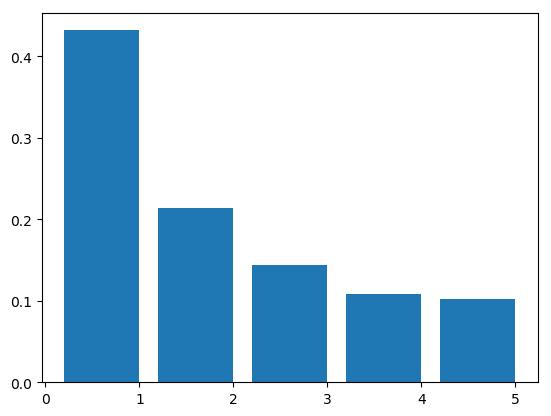

In [3]:
plt.style.use('default')
rho = np.random.rand(M)
rho /= sum(rho)
plt.bar(np.arange(M) + 0.6, rho, width=0.8)

We'll then pick 1000 random reads of length 5 each.

In [4]:
def random_read(s, rho, L):
    chosen_seq = np.random.choice(s, p=rho)
    start_idx = np.random.randint(0, len(chosen_seq) - L)
    end_idx = start_idx + L
    return chosen_seq[start_idx:end_idx]
        
N = 1000 # Number of reads
L = 5

reads = []
for i in range(N):
    reads.append(random_read(transcripts, rho, L))
    
print('First 10 reads...', reads[0:10])

First 10 reads... ['ATATC', 'CGATA', 'CCAGT', 'CGACG', 'TCGAC', 'GCACT', 'TCGAC', 'AGTTC', 'GACGC', 'CGACG']


In the code below, implement a way to compute the compatibility matrix $A$ as well as the EM algorith itself. Then, run the algorithm for 100 iterations and report your estimated distribution of $\rho$ (store it in ```rho_est```).

In [5]:
N_iter = 100 #number of E/M iterations

rho_est = np.array([1/5, 1/5, 1/5, 1/5, 1/5])

In [6]:
# Compute your compatibility matrix here.
A = np.zeros((N, M))

for n, read in enumerate(reads):
    for m, transcript in enumerate(transcripts):
        if read in transcript:
            A[n][m] = 1

# Implement the EM algorithm here.
for i in range(N_iter):
    
    # 1. E step
    for n, row in enumerate(A):
        for m in range(M):
            if row[m]:
                row[m] = rho_est[m]
        row /= sum(row)
        
    # 2. M step
    rho_est = np.sum(A, 0) / N


Your estimated distribution should look similar to the real distribution.

In [7]:
print('(real) rho', rho)
print('(est.) rho', rho_est)

(real) rho [0.43181439 0.21418413 0.14362923 0.10830976 0.10206248]
(est.) rho [0.45051313 0.19164474 0.1236629  0.11548687 0.11869236]


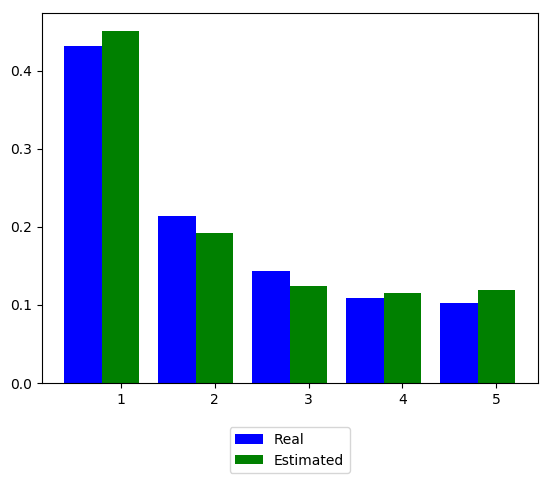

In [8]:
plt.bar(np.arange(M) + 0.6, rho, color='blue', width=0.4, label='Real')
plt.bar(np.arange(M) + 1, rho_est, color='green', width=0.4, label='Estimated')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1))
plt.show()

### 3c. Run the same EM algorithm on our bigger dataset.

Let's try running the same algorithm on much more data. In particular, we'll be looking at an application of RNA sequencing where studying the relative abundance of certain short transcripts called microRNA's can help determine whether a patient with chronic lymphocytic leukemia has the slow growing form or the aggressive form of the disease (https://en.wikipedia.org/wiki/MicroRNA). Here, we've loaded in 200 transcripts, each of length 20, as well as 10000 reads for each of three patients. A higher proportion of the first 10 transcripts indicate that the patient has the aggressive form of the disease. Your job is to use the EM algorithm to determine which patients have which form of the disease.

In [9]:
M, N = 200, 10000
transcripts = np.load('transcripts.npy')
all_reads = np.load('reads.npy')
patient1_reads = all_reads[0]
patient2_reads = all_reads[1]
patient3_reads = all_reads[2]

In [10]:
# Your code here.
def em(patient_read):
    rho_est = np.ones(M) / M
    
    A = np.zeros((N, M))

    for n, read in enumerate(patient_read):
        decoded_read = read.decode('utf-8')
        for m, transcript in enumerate(transcripts):
            if decoded_read in transcript.decode('utf-8'):
                A[n][m] = 1

    # Implement the EM algorithm here.
    for i in range(N_iter):
        # 1. E step
        for n, row in enumerate(A):
            for m in range(M):
                if row[m]:
                    row[m] = rho_est[m]
            row /= sum(row)

        # 2. M step
        rho_est = np.sum(A, 0) / N
        
    return rho_est

In [11]:
em(patient1_reads)

array([0.00541729, 0.001679  , 0.00473046, 0.00595705, 0.00261754,
       0.00643172, 0.00723306, 0.00405617, 0.00525871, 0.00551072,
       0.00651398, 0.00445013, 0.00494876, 0.00485765, 0.00670219,
       0.00731319, 0.00561787, 0.00333173, 0.00301802, 0.00427677,
       0.00451226, 0.0063837 , 0.00581761, 0.00484347, 0.00482882,
       0.0063663 , 0.00689057, 0.00229953, 0.00491203, 0.00456743,
       0.00376682, 0.00285193, 0.00545523, 0.00429941, 0.00467595,
       0.0043489 , 0.00505256, 0.00750195, 0.00611995, 0.00605392,
       0.0044836 , 0.00356195, 0.0042359 , 0.00492321, 0.00713622,
       0.00705564, 0.00560358, 0.00585206, 0.00258124, 0.00370784,
       0.00543403, 0.00473652, 0.0058828 , 0.0051982 , 0.00585583,
       0.00542204, 0.00595881, 0.00568416, 0.00797031, 0.00283366,
       0.00656183, 0.00505218, 0.00661439, 0.00351364, 0.0042074 ,
       0.00794066, 0.00610794, 0.00368812, 0.00350096, 0.00308639,
       0.00296652, 0.00404257, 0.00861633, 0.00570306, 0.00610

In [12]:
em(patient2_reads)

array([0.00612361, 0.00454363, 0.00461821, 0.00579537, 0.00391933,
       0.00268534, 0.00892519, 0.0056463 , 0.00538047, 0.00580128,
       0.00309136, 0.0040513 , 0.00450479, 0.00428065, 0.00438479,
       0.00602174, 0.00512896, 0.00674594, 0.00477065, 0.00426288,
       0.00566422, 0.01122343, 0.00220747, 0.00777698, 0.00587014,
       0.00596558, 0.00569508, 0.00632076, 0.00208504, 0.00617077,
       0.00575725, 0.00413221, 0.00355541, 0.00462682, 0.00366214,
       0.00451548, 0.00391927, 0.00470173, 0.00228906, 0.00749436,
       0.00622356, 0.00411368, 0.00373826, 0.00344577, 0.00586486,
       0.0067551 , 0.00342974, 0.0046489 , 0.00085381, 0.00322756,
       0.00566126, 0.00355081, 0.00415682, 0.0043824 , 0.00503615,
       0.00409313, 0.00737804, 0.00585467, 0.00675039, 0.00406275,
       0.00393646, 0.00634348, 0.00536957, 0.00427079, 0.00677104,
       0.00382541, 0.00420023, 0.00561096, 0.00793183, 0.00247248,
       0.00535509, 0.00293042, 0.00563537, 0.00654799, 0.00606

In [13]:
em(patient3_reads)

array([0.01398914, 0.01623418, 0.0136143 , 0.01398143, 0.01744219,
       0.01717646, 0.01384525, 0.01792051, 0.01577271, 0.01583132,
       0.00192867, 0.00339653, 0.00521563, 0.006172  , 0.00509958,
       0.0047946 , 0.00108303, 0.00626465, 0.00653673, 0.00322165,
       0.00514334, 0.00693018, 0.00465672, 0.00606398, 0.00576299,
       0.00558244, 0.00529325, 0.00280966, 0.00176589, 0.00539614,
       0.00130382, 0.00403037, 0.00216875, 0.00372381, 0.00264616,
       0.00181815, 0.00458642, 0.0025847 , 0.00287754, 0.0040666 ,
       0.00635633, 0.00119177, 0.00528608, 0.00484938, 0.00499568,
       0.00446874, 0.00324311, 0.00592388, 0.0022479 , 0.00232329,
       0.00432696, 0.0042135 , 0.00332761, 0.005095  , 0.00411811,
       0.00800153, 0.00438084, 0.00553138, 0.00652907, 0.00291937,
       0.00343247, 0.00510191, 0.00744808, 0.00292938, 0.00479929,
       0.0024738 , 0.00437907, 0.00264534, 0.00523808, 0.00438322,
       0.00283865, 0.00672531, 0.00351787, 0.00468613, 0.00590

Congratulations -- you've just finished your last lab for EE 126!

Take a minute to appreciate what you've accomplished throughout the semester. This class wasn't easy, but hopefully you've learned a lot! Come see us if you'd like some help figuring out where to go from here.

## References

[1] L. Pachter. Models for transcript quantification from RNA-Seq. available at arXiv:1104.3889 [q-bio.GN], 2011. <br />
[2] A. Roberts and L. Pachter, RNA-Seq and find: entering the RNA deep field, Genome Medicine, 3 (2011), 74.<br/>
[3] C. Do and S. Batzoglou, What is the expectation maximization algorithm? Nature Biotechnology, 26 (2008), 8.